In [1]:
import os
import random
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
from tensorflow.keras import layers, Model
import tensorflow as tf
from tensorflow import keras
import numpy as np

import utils
from segmentation_3.model import OxfordPets

root = "C:/Users/luke_/Desktop/Dev/ee544-computer-vision/segmentation_3/saved_models"
# model = f"{root}/xception_style_unet.h5"
# model_fl = f"{root}/unet_2.h5"
# model_fl = f"{root}/unet_3.h5"
model_fl = f"{root}/unet_5.h5"
# img_size = (160, 160)  # original U-Net dims was 572, 572 but hitting GPU OOM
# img_size = (128, 128)  # original U-Net dims was 572, 572 but hitting GPU OOM
img_size = (256, 256)  # original U-Net dims was 572, 572 but hitting GPU OOM

model = tf.keras.models.load_model(model_fl)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         rescaling[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
______________________________________________________________________________________________

In [2]:
data_fldr = utils.data_fldr + "/oxford-iiit-pet"
input_dir = f"{data_fldr}/images/"
target_dir = f"{data_fldr}/annotations/trimaps/"
num_classes = 3
batch_size = 1  # original U-Net batch size "...to make maximum use of GPU..." with large images
PADDING = "same"  # original U-net "unpadded"

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)


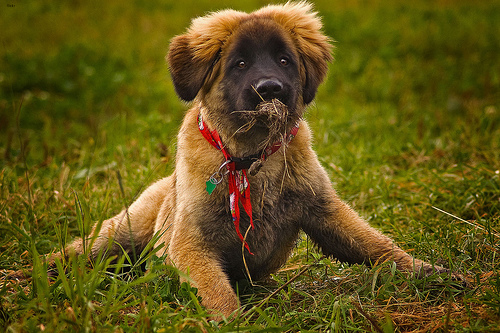

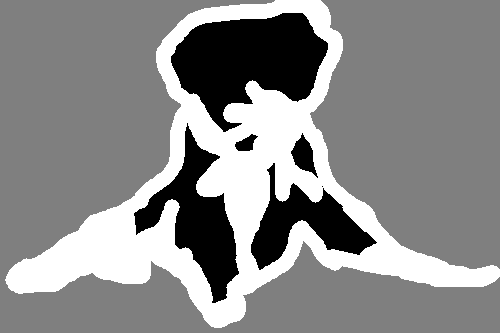

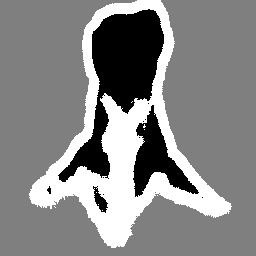

In [3]:
# # train first 1000 images
# input_img_paths = input_img_paths[0:1000]
# target_img_paths = target_img_paths[0:1000]
# Split our img paths into a training, validation & sets
val_samples = 1000
test_samples = 500
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-(val_samples+test_samples)]
train_target_img_paths = target_img_paths[:-(val_samples+test_samples)]
val_input_img_paths = input_img_paths[-(val_samples+test_samples):-test_samples]
val_target_img_paths = target_img_paths[-(val_samples+test_samples):-test_samples]

test_input_img_paths = input_img_paths[-test_samples:]
test_target_img_paths = target_img_paths[-test_samples:]

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  #

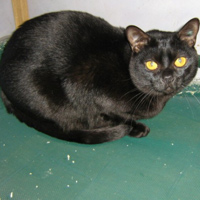

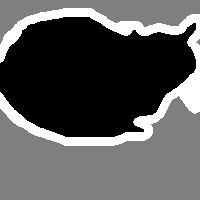

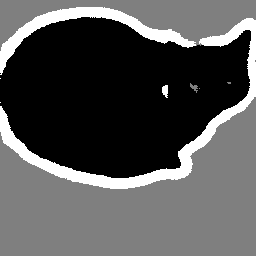

In [5]:
# make prediction on test set

test_gen = OxfordPets(batch_size, img_size, test_input_img_paths, test_target_img_paths)
test_preds = model.predict(test_gen)

def display_mask(pred):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(pred, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

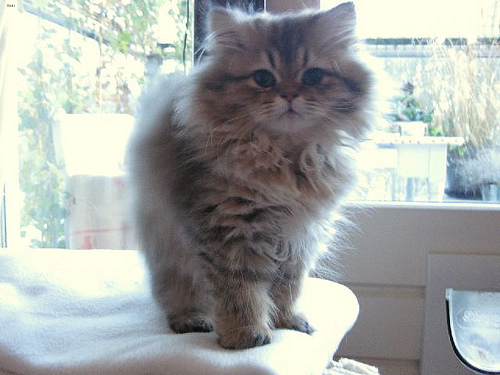

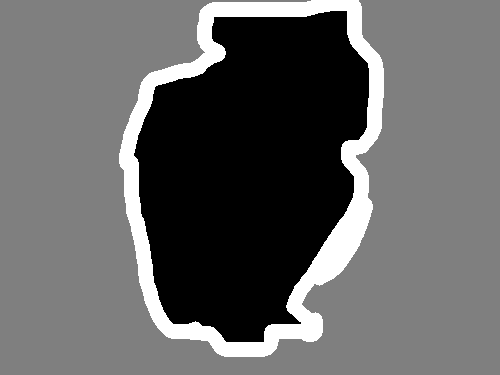

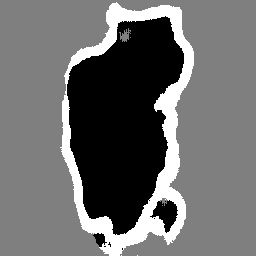

In [19]:
# Display results for test image #i
i = 200

# Display input image
display(Image(filename=test_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(test_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(test_preds[i])  #

In [ ]:
for i in range(len(val_input_img_paths)):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    img = img.save(f"predictions/{val_target_img_paths[i]}")